# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Paths

In [2]:
# snakemake output
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# jupyter notebook output
tree_df_path = "../../results/parse_tree/parse_tree.tsv"
tree_df_dill = "../../results/parse_tree/parse_tree.df.obj"
tree_path = "../../results/parse_tree/parse_tree.nwk"
auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

# static dir
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"


outdir = "../../results/clock_model"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

# Clock model params

N_IQD = 3
MAX_ITER = 3
TC = "skyline"

## Import Tree

In [4]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

In [8]:
# Initialize stdout capture
# print("Estimating clock model...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# branch_length_mode:input --> tMRCA ~20,000 YBP

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )

tt.run(
    # Stable Parameters
    max_iter=1,    
    n_iqd=N_IQD,   
    verbose=4,    
    infer_gtr=True,  
    use_covariation=False,     
    root=tt.tree.root,       
    resolve_polytomies=True,     
    vary_rate=True,    
    relaxed_clock={"slack" : 0.1, "coupling": 0},     
    # Variable Parameters   
    branch_length_mode = "joint", # joint or marginal      
    #time_marginal=True,   # True, False or "assign"  
    #Tc=TC,    
    )

tt.tree.ladderize(reverse=False)

# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_estimate.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.09	-SequenceData: loaded alignment.
1.09	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.09	-SeqData: making compressed alignment...

3.76	-SequenceData: constructed compressed alignment...
4.04	--ClockTree: Setting precision to level 2

4.10	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.

4.10	-TreeAnc.optimize_tree: sequences...

4.10	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

4.10	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
4.10	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
4.10	---TreeAnc._ml_anc_jo

126.42	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
126.60	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

208.09	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.09	---TreeTime._poly.merge_nodes: Delta-LH = 0.026
208.12	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.12	---TreeTime._poly.merge_nodes: Delta-LH = 0.003
208.16	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.16	---TreeTime._poly.merge_nodes: Delta-LH = 0.002
208.19	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.19	---TreeTime._poly.merge_nodes: Delta-LH = 0.001
208.23	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.23	---TreeTime._poly.merge_nodes: Delta-LH = 0.0
208.26	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.26	---TreeTime._poly.merge_nodes: Delta-LH = 0.0
208.30	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.30	---TreeTime._poly.merge_nodes: Delta-LH = 0.0
208.33	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
208.33	---Tre

210.45	---TreeTime._poly.merge_nodes: creating new node as child of NODE433
210.45	---TreeTime._poly.merge_nodes: Delta-LH = 0.001
210.51	---TreeTime._poly.merge_nodes: creating new node as child of NODE565
210.51	---TreeTime._poly.merge_nodes: Delta-LH = 0.018
210.55	---TreeTime._poly.merge_nodes: creating new node as child of NODE551
210.55	---TreeTime._poly.merge_nodes: Delta-LH = 0.058
210.58	---TreeTime.resolve_polytomies: introduces 67 new nodes

210.72	-TreeAnc.optimize_tree: sequences...

210.72	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint
210.72	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
210.72	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
215.97	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
216.11	---TreeAnc._ml_anc_joint: ...done

216.12	-TreeAnc.optimize_branch_length: running branch length optimization using
      	 jointML ancestral sequences
221.30	--TreeA

333.65	--ClockTree.date2dist: Setting new molecular clock. rate=9.332e-09,
      	  R^2=0.2997
333.66	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
333.66	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
333.66	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
333.66	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
333.66	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
333.66	---

477.02	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
477.18	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

557.26	--###ClockTree.calc_rate_susceptibility: rate: 0.000000,
      	  LH:-680006505174.651367

557.28	TreeTime: the following tips have been marked as outliers. Their date
      	constraints were not used. Please remove them from the tree. Their dates
      	have been reset:

557.28	GCA_001601675.1_ASM160167v1_genomic, input date: 1999.0, apparent date:
      	3245.99

557.28	GCA_001972405.1_ASM197240v1_genomic, input date: 1995.0, apparent date:
      	2794.20

557.28	GCA_001972385.1_ASM197238v1_genomic, input date: 1988.0, apparent date:
      	2852.08

557.28	GCA_001972395.1_ASM197239v1_genomic, input date: 1984.0, apparent date:
      	3066.16

557.28	GCA_002165475.1_ASM216547v1_genomic, input date: 2010.0, apparent date:
      	3111.87

557.28	GCA_001972415.1_ASM197241v1_genomic, input date: 1969.0, apparent date:
      	3431.80

557.28	GCA_001294815.1_ASM129481v1_genomic, input date: 1983.0, apparent date:
      	2198.31

557.28	GCA_000382505.1_Yersinia_pestis_G1670E_assembly_

## Quick Checks

In [10]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=2.148814885614286e-07, clock_length=2.148814885614286e-07, date='-4057-09-21', dist2root=0.0, mutation_length=2.148814885614286e-07, name='NODE0', original_length=0.0)

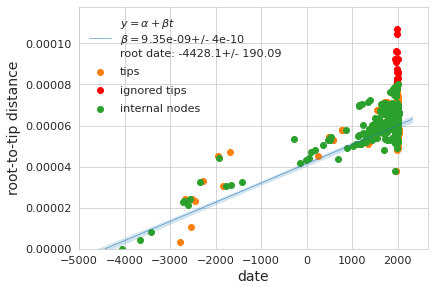

In [11]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

In [12]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

PRUNING: GCA_001601675.1_ASM160167v1_genomic
PRUNING: GCA_001972405.1_ASM197240v1_genomic
PRUNING: GCA_001972385.1_ASM197238v1_genomic
PRUNING: GCA_001972395.1_ASM197239v1_genomic
PRUNING: GCA_002165475.1_ASM216547v1_genomic
PRUNING: GCA_001972415.1_ASM197241v1_genomic
PRUNING: GCA_001294815.1_ASM129481v1_genomic
PRUNING: GCA_000382505.1_Yersinia_pestis_G1670E_assembly_genomic
PRUNING: GCA_000382545.1_Yersinia_pestis_assembly_genomic
PRUNING: GCA_001188335.1_DYA_1_genomic
PRUNING: GCA_000834275.1_ASM83427v1_genomic
PRUNING: GCA_000834885.1_ASM83488v1_genomic
PRUNING: GCA_008630375.1_ASM863037v1_genomic
PRUNING: GCA_008630375.2_ASM863037v2_genomic
PRUNING: GCA_002412305.1_Y.pestis_A-1809_genomic
PRUNING: GCA_003086075.1_ASM308607v1_genomic
PRUNING: GCA_003086115.1_ASM308611v1_genomic
PRUNING: GCA_001613865.1_ASM161386v1_genomic


## Plot Prune Comparison: Divtree

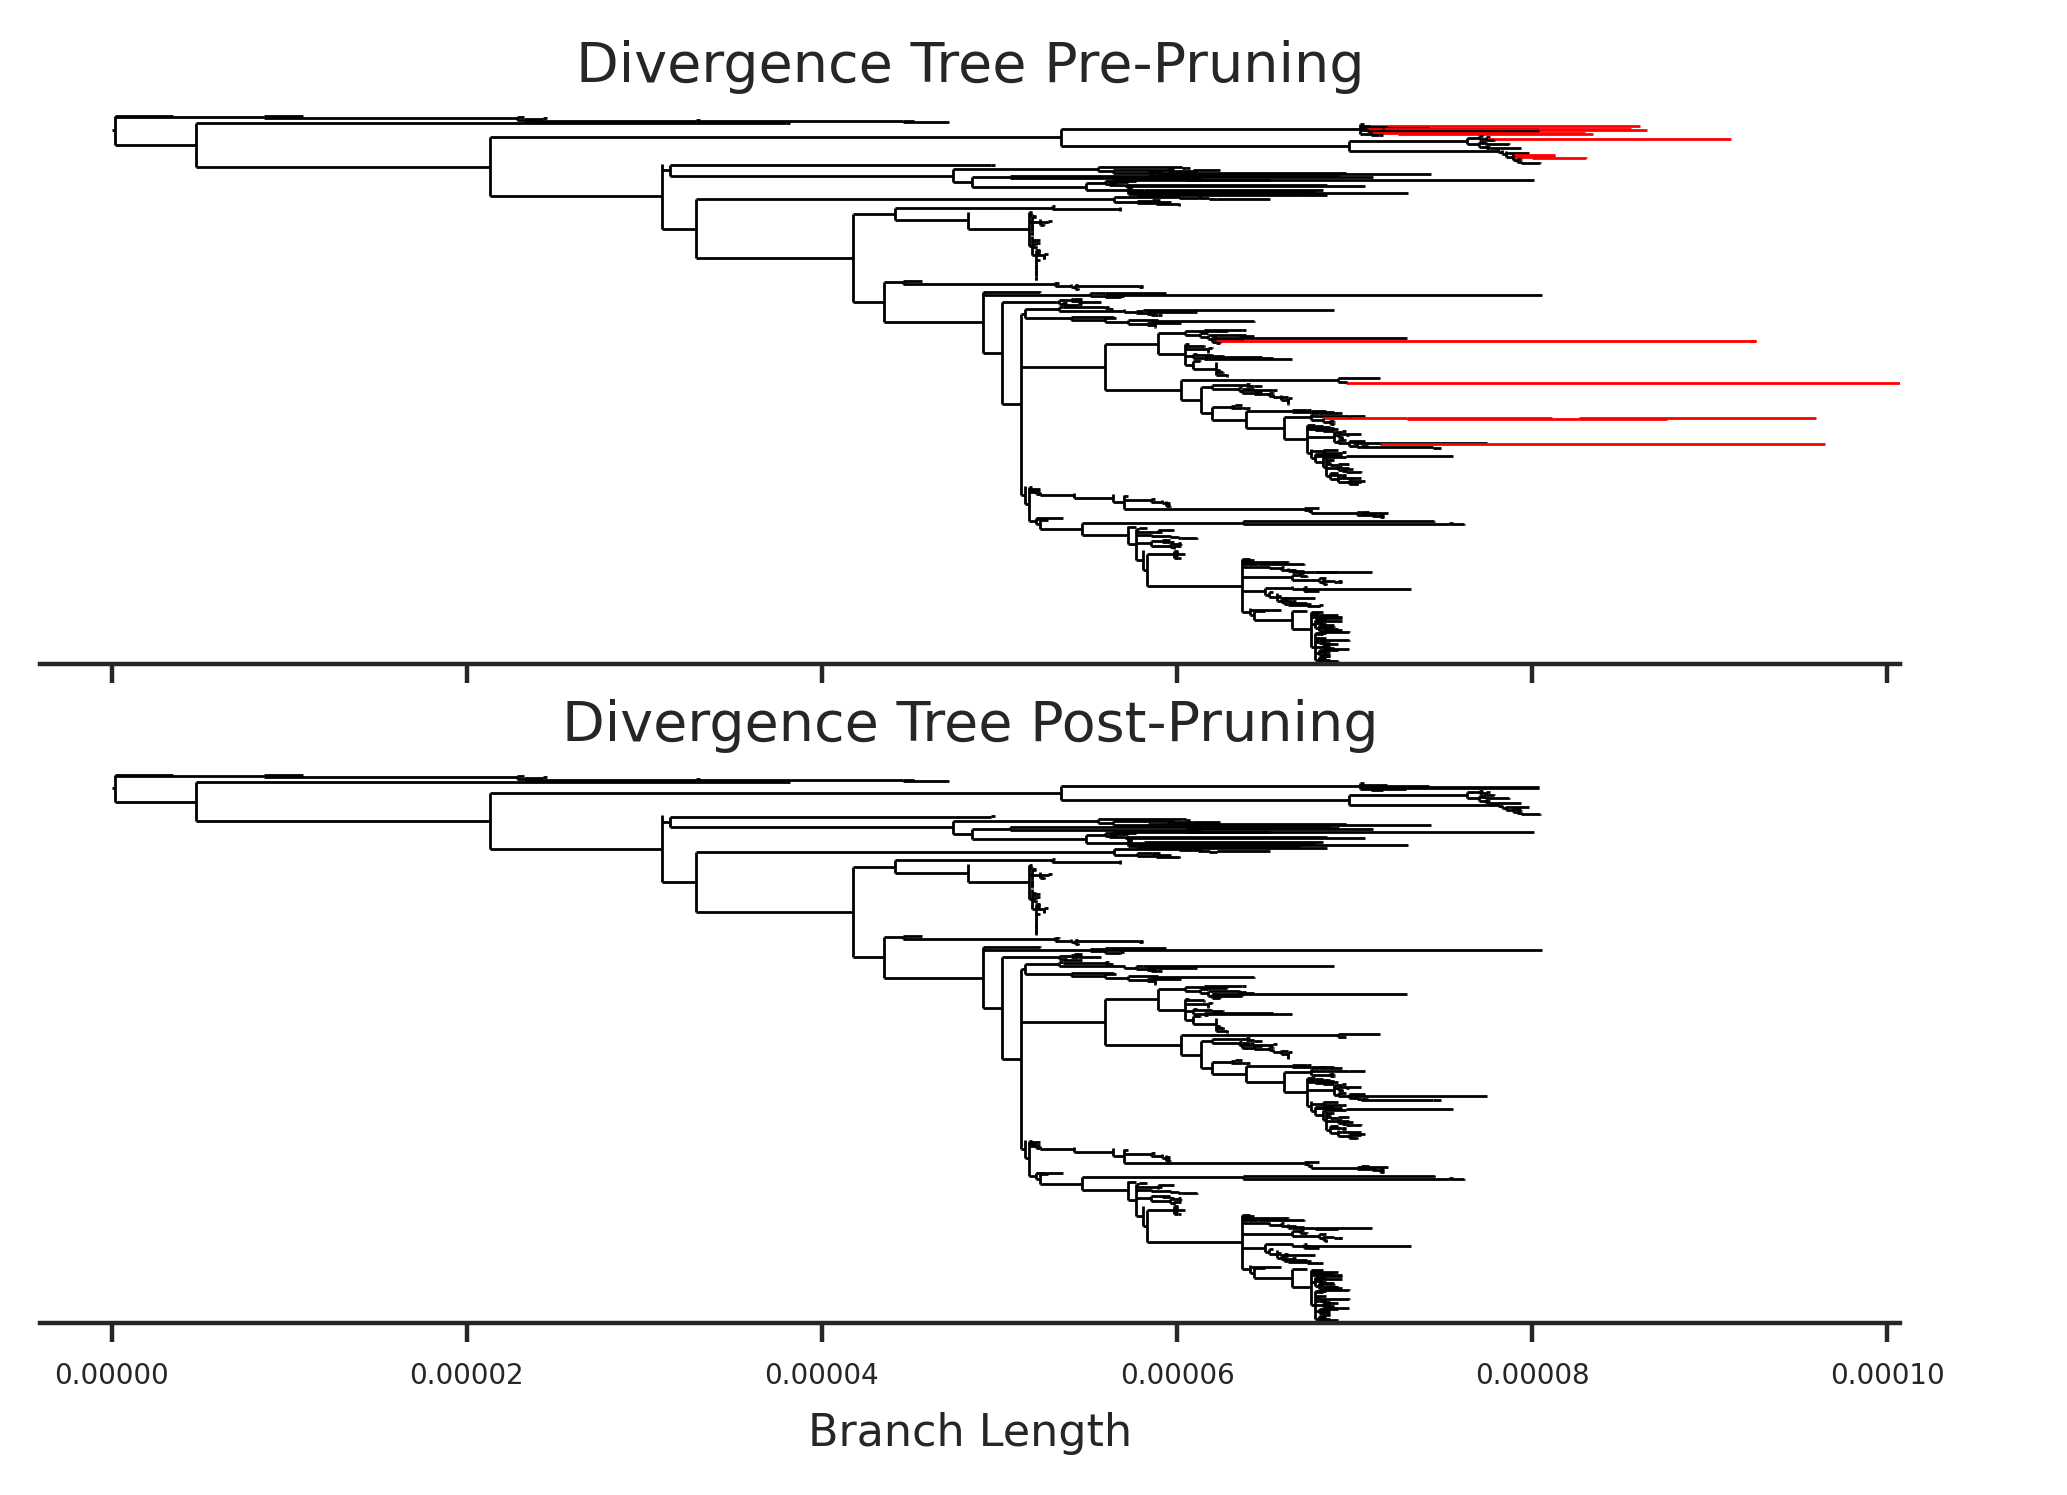

In [19]:
sns.set_style("ticks")
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Plot Prune Comparison: Timetree

1311.58	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years
1326.20	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


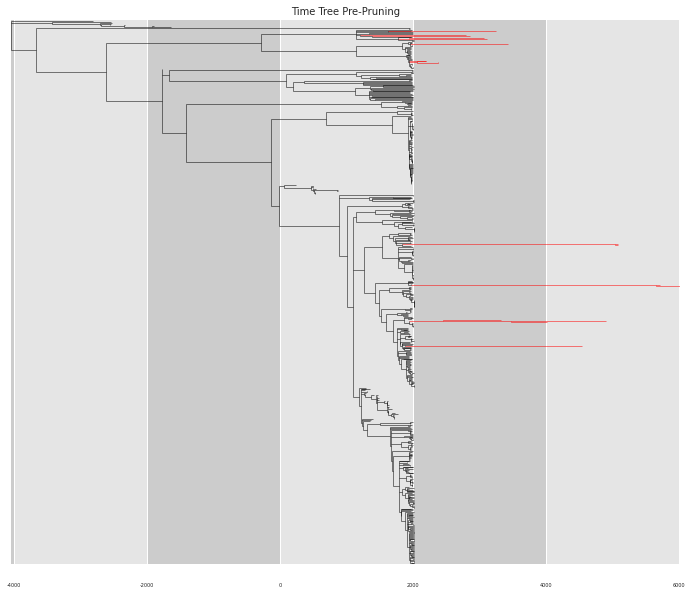

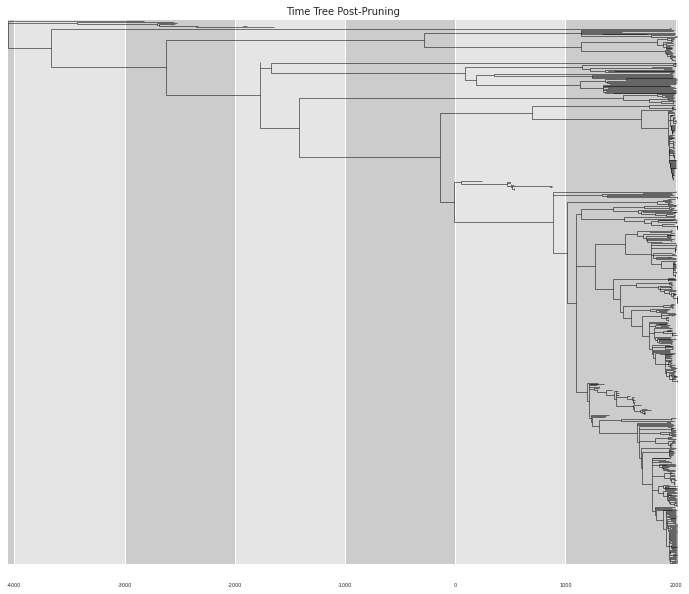

In [26]:
# Pre-pruning
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"" ,do_show=False)  

ax1.set_title("Time Tree Pre-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-pre." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# Post-pruning    
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"" ,do_show=False)  

ax2.set_title("Time Tree Post-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-post." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [27]:
tt = tt_prune

## Remove Collapsed Nodes from Dataframe

In [28]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000077,631.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [29]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [30]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Set the boolean flag on the first time encountered
        if not HAS_MARGINAL:
            HAS_MARGINAL = True
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE:
            print("Bad lower date estimated for:", c.name,"\t", conf_range, "\tSetting to", c.numdate)       
            conf[0] = c.numdate
            conf[1] = c.numdate
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

1362.70	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


## RTT

In [31]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

1363.29	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.354424e-09,1.000000,2.148815e-07,-4057-09-21,-4056.278968,0.100000,0.100000,16.189925,-4056.278968,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.783127e-09,0.297520,3.224841e-06,-2824-11-13,-2823.132203,1233.146765,1233.246765,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.346755e-08,1.439698,8.391091e-06,-3429-12-15,-3428.044176,628.234792,628.334792,3.156250,-3428.044176,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.450589e-09,0.261971,2.150121e-06,-2552-11-29,-2551.089382,876.954794,1505.289586,2.000000,-2546.500000,0.000011,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.007384e-08,2.145919,1.421497e-05,-2709-06-04,-2708.577895,719.466281,1347.801073,4.312500,-2708.577895,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000276,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.354424e-09,1.000000,3.009513e-22,1968-06-09,1968.439450,0.000000,6024.818418,357.500000,1968.439450,0.000069,False
NODE_0000307,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.354424e-09,1.000000,3.013759e-22,2015-01-01,2015.000107,1.318735,6071.379075,409.500000,2015.000107,0.000070,False
NODE_0000316,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.354424e-09,1.000000,2.830491e-22,1460-08-27,1460.653514,0.247471,5517.032482,424.500000,1460.653514,0.000057,False


## Skyline

In [33]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

## Add Metadata as Comments

In [49]:
metadata_to_comment(tt.tree, tree_df)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



---
# Export

## Tree and Dataframe

In [50]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + ".treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt, outfile)
    
# Newick (remove comments)
for c in tt.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [47]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 3.406511935876896e-08, 'rate_fold_change': 3.641605119596116, 'mutation_length': 1.7200266924678808e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'clock_length': 46.53731251323006}


## Auspice JSON

In [48]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/clock_model/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/clock_model/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
